In [1]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.models as models

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import accuracy_score
import pylab as pl
from IPython import display
from skimage import io
from skimage.transform import rescale
import datetime

# Functions

In [3]:
class Trainloader:
    
    def __init__(self,classfolder,croppedfolder,picturesize,batchsize,split_ratio):
        self.classdirectory = classfolder
        self.cropdirectory = croppedfolder
        self.picturesize = picturesize
        self.split_ration = split_ratio
        self.batchsize = batchsize
        self.classlist = self._getclasses()
        self.countlist = self._get_countlist()
        self.onehot = self._get_onehot()
        self.trainsplit,self.validsplit = self._train_valid_split(split_ratio)
        self.batchnumber = 0
        
    
    def _getclasses(self):
        classlist = [x[1] for x in os.walk(self.classdirectory)][0]
        classlist.sort()
        
        return classlist
    
    def _get_countlist(self):
        countlist = []

        for i, klasse in enumerate(self.classlist):
            output = os.listdir("{}{}".format(self.classdirectory,klasse))    
            path, dirs, files = next(os.walk("{}{}".format(self.classdirectory,klasse)))
            file_count = len(files)
            countlist.append(file_count)

        return countlist
    
    def _get_onehot(self):
        for i,currentClass in enumerate(self.classlist):
            pictures = os.listdir("{}/{}".format(self.classdirectory,currentClass))
            df1 = pd.DataFrame([pictures,[1 for i in range(len(pictures))]]).T
            df1.columns=['picture',currentClass]
            if i != 0:
                onehot = pd.merge(df1,onehot,on='picture',how='outer')
            else:
                onehot = df1.copy()
        
        onehot = onehot.fillna(value=0)
        onehot = onehot.set_index('picture')
        return onehot
    
    def _convert_picture(self,path):
        image = io.imread(path)
        rescale_factor = self.picturesize / image.shape[0],self.picturesize / image.shape[1]
        scaled = rescale(image, rescale_factor, anti_aliasing=False, multichannel=True,mode='constant')[:,:,:3]
        scaled = scaled.transpose((-1, 0, 1))

        return scaled
    
    def _get_pictures(self,paths):
        trainlist = []
        for path in paths:
            trainlist.append(self._convert_picture(self.cropdirectory+path))
            
        return trainlist
    
    def _train_valid_split(self,split_ratio):
        split = self.onehot.index.tolist()
        
        
        train = split[:int(len(split)*split_ratio)]
        valid = split[int(len(split)*split_ratio):]
        
        validsplit = []
        for i in range(0,len(valid),self.batchsize):
             validsplit.append(valid[i:i + self.batchsize])
                
        trainsplit = []
        for i in range(0,len(train),self.batchsize):
             trainsplit.append(train[i:i + self.batchsize])
        
        return trainsplit, validsplit
        
    
    def train_next(self):
        try:
            paths = self.trainsplit[self.batchnumber]
            pictures = self._get_pictures(paths)
            targets = self.onehot.loc[paths].values
        
            self.batchnumber += 1
        
            return pictures, targets
        
        except:
            self.batchnumber = 0
            return None, None
    
    def valid_next(self):
        try:
            paths = self.validsplit[self.batchnumber]
            pictures = self._get_pictures(paths)
            targets = self.onehot.loc[paths].values
        
            self.batchnumber += 1
        
            return pictures, targets
        
        except:
            self.batchnumber = 0
            return None, None
        
    
    def print_classes(self):
        
        for i in range(len(self.classlist)):
            print(f"Class: {i} - {self.countlist[i]}\t\t - {self.classlist[i]}")
        
        

In [93]:
def calculate_precision(pred, true):
    predicted_positives = (np.array(pred) == 1).sum()
    
    true_positives = np.array([a == b and a == 1 for a, b in zip(pred, true)])
    true_positives = (np.array(true_positives) == 1).sum()

    result = true_positives / predicted_positives
    
    return result

def AP(pred, true):
    precision = calculate_precision(pred, true)
    a = np.array([a == b and a == 1 for a, b in zip(pred, true)])
    score = (np.array(a) ==True).sum() * precision
    
    result = score / K
    
    return result



def MAP(predicted_data, true_data):
    result = np.array([AP(pred, true) for pred, true in zip(predicted_data, true_data)]).sum() / K

    return result

In [77]:
def prepare_data(batch=None,labels=None):
    if batch != None:
        # prepare data
        batch = torch.tensor(batch).float()
        labels = torch.tensor(labels).float()
        device = torch.device("cuda:0" if cuda else "cpu")
        #print("Using device:", device)

        batch = batch.to(device)
        labels = labels.to(device)

        return batch,labels
    else:
        return none,none

In [5]:
#define the model
model_conv = models.resnet50(pretrained='imagenet')

# disable autograd for resnet
for param in model_conv.parameters():
    param.requires_grad = False
    
# Change fully connected layer to match paper (autograd is default on new layers)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 1024)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)

# Prepare dataloader

In [6]:
classfolder="./dataset_v2/root/train/classes/"
croppedfolder = "./dataset_v2/root/train/cropped/"
picturesize = 224
batchsize = 64
split_ratio = 0.8

In [7]:
trainloader = Trainloader(classfolder,croppedfolder,picturesize,batchsize,split_ratio)
flattened = [val for sublist in trainloader.validsplit for val in sublist]

dataset_positives = 0.0
for column in trainloader.onehot.loc[flattened].columns:
    dataset_positives += trainloader.onehot.loc[trainloader.onehot[column] == 1].sum()[column]

# Prepare network

In [41]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  
        # input layer
        output_nodes = trainloader.onehot.shape[1]
        self.output = nn.Linear(1024,output_nodes)
       

    def forward(self, x):
        x = model_conv(x)
        x = F.relu(x)
        x = self.output(x)
        x = F.sigmoid(x)
        return x


net = Net()

cuda = torch.cuda.is_available()
if cuda:
    net.cuda()

# Training loop

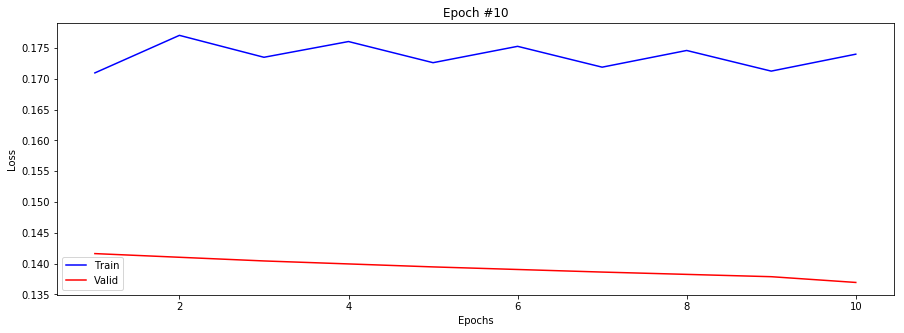

Training loss: 0.17
Validation loss:0.14	Validation accuracy: 0.00

					Training time 0:25:53.247999


In [109]:
%matplotlib inline
epochs = 100
threshold = 0.5
valid_every = 2
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) 

losses_train = pd.DataFrame(columns=['Epoch','Loss'])
losses_valid = pd.DataFrame(columns=['Epoch','Loss'])

accuracy = 0.01 #dummy value

now = datetime.datetime.now()

for epoch in range(epochs):
    batch_loss = []
    
    net.train()
    
    batch,labels = trainloader.train_next() 
    
    while batch != None:
        #prepare data
        batch,labels = prepare_data(batch,labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        output = net(batch)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
        
        batch,labels = trainloader.train_next()
        
       
    losses_train.loc[epoch] = [epoch+1,np.mean(batch_loss)]
    
    if epoch%valid_every == 0 or epoch == max(range(epochs)):
        batch_loss = []
        net.eval()
        running_correct = 0
        preds = []
        trues = []
        
        batch,labels = trainloader.valid_next()
        while batch != None:
            #prepare data
            batch,labels = prepare_data(batch,labels)
            # zero the parameter gradients
            optimizer.zero_grad()

            output = net(batch)
            loss = criterion(output,labels)
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())
            
            #labels_ = torch.reshape(labels,(-1,))
            #preds = torch.Tensor([1 if pred > threshold else 0 for sample in output for pred in sample]).to(device)
            preds.append([[1 if pred > threshold else 0 for pred in sample] for sample in output])
            trues.append([[int(value) for value in valuelist] for valuelist in labels.tolist()])
            
            #running_correct += torch.sum(torch.Tensor([predicted for predicted,correct in zip(preds,labels_) if predicted == correct]))
            #running_correct = MAP(preds, trues)
            
            
            batch,labels = trainloader.valid_next()
            
        losses_valid.loc[epoch] = [epoch+1,np.mean(batch_loss)]
        accuracy = MAP(preds[0], trues[0])
    
    pl.figure(figsize=(15,5))
    pl.xlabel('Epochs')
    pl.ylabel('Loss')
    pl.title('Epoch #{}'.format(epoch+1))
    pl.plot(losses_train['Epoch'],losses_train['Loss'], '-b', label='Train')
    pl.plot(losses_valid['Epoch'],losses_valid['Loss'], '-r', label='Valid')
    pl.legend()
    pl.show()
    print('Training loss: {:.2f}'.format(losses_train['Loss'].iloc[-1],))
    print('Validation loss:{:.2f}\tValidation accuracy: {:.2f}'.format(losses_valid['Loss'].iloc[-1],accuracy))
    display.clear_output(wait=True)
    

    
pl.figure(figsize=(15,5))
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.title('Epoch #{}'.format(epoch+1))
pl.plot(losses_train['Epoch'],losses_train['Loss'], '-b', label='Train')
pl.plot(losses_valid['Epoch'],losses_valid['Loss'], '-r', label='Valid')
pl.legend()
pl.show()

print('Training loss: {:.2f}'.format(losses_train['Loss'].iloc[-1],))
print('Validation loss:{:.2f}\tValidation accuracy: {:.2f}'.format(losses_valid['Loss'].iloc[-1],accuracy))

print("\n\t\t\t\t\tTraining time {}".format(datetime.datetime.now()-now))